In [1]:
import sys
sys.path.insert(0,'/mnt/Sol_train/transformer3_clean')
import random
import time
import numpy as np, pandas as pd
from tqdm import tqdm
from math import log10
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch_geometric.transforms as T
from torch.utils.data import random_split, DataLoader

from dataset import fn, custom_InMemoryDataset, NewDataset_w_sph
from train import *
from model import Gradformer_DownstreamTasks 

In file included from /opt/conda/lib/python3.9/site-packages/numpy/core/include/numpy/ndarraytypes.h:1929,
                 from /opt/conda/lib/python3.9/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /opt/conda/lib/python3.9/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from /home/ubuntu/.pyxbld/temp.linux-x86_64-cpython-39/mnt/Sol_train/transformer3_clean/src/algos.c:1240:
/opt/conda/lib/python3.9/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~
In file included from /opt/conda/lib/python3.9/site-packages/numpy/core/include/numpy/ndarraytypes.h:1929,
                 from /opt/conda/lib/python3.9/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /opt/conda/lib/python3.

In [2]:
df= pd.read_csv('/domino/datasets/local/Sol_pred_Jiaxi/data_processing/clean_compile_v2_correction.csv', na_values = ['NAN', '?','NaN'])
df= df.head(3000)
print(df.notnull().sum())

SMILES                                     3000
JNJNUMBER                                  3000
CHI LogD/LogP_Cyprotex CHI LogP            2569
CHI LogD/LogP_Cyprotex CHI LogD pH 2.6     2593
CHI LogD/LogP_Cyprotex CHI LogD pH 7.4     2686
CHI LogD/LogP_Cyprotex CHI LogD pH 10.5    2668
sol_ph2                                     340
sol_ph7                                     362
fassif                                       24
S0                                          346
indicator                                  3000
dtype: int64


In [3]:
def tolog10(x):
    try:    o= log10(x/1000000)
    except:        o= np.nan
    return o
log10porp= ['sol_ph2', 'sol_ph7']
for p in log10porp:
    df[f'log10_{p}']=df[p].apply(tolog10)

nonlog10=['CHI LogD/LogP_Cyprotex CHI LogD pH 7.4',
 'CHI LogD/LogP_Cyprotex CHI LogD pH 10.5',
 'CHI LogD/LogP_Cyprotex CHI LogD pH 2.6',
 'CHI LogD/LogP_Cyprotex CHI LogP','S0'] 
properties=nonlog10+ [f'log10_{s}' for s in log10porp] 
properties

['CHI LogD/LogP_Cyprotex CHI LogD pH 7.4',
 'CHI LogD/LogP_Cyprotex CHI LogD pH 10.5',
 'CHI LogD/LogP_Cyprotex CHI LogD pH 2.6',
 'CHI LogD/LogP_Cyprotex CHI LogP',
 'S0',
 'log10_sol_ph2',
 'log10_sol_ph7']

In [4]:
df_clean=df

In [5]:
train_df, test_valid = train_test_split( df_clean,  test_size=0.3 , stratify=df_clean['indicator'].values,random_state =44)
test_df, validation = train_test_split( test_valid,  test_size=0.5, stratify=test_valid['indicator'].values,random_state =44)

train_df.reset_index(drop=True , inplace=True)
test_df.reset_index(drop=True , inplace=True)
validation.reset_index(drop=True , inplace=True)

In [6]:
folder='clean_code_run1'
!mkdir {folder}

mkdir: cannot create directory ‘clean_code_run1’: File exists


In [7]:
train_df.to_csv(f'{folder}/Training_data_ALL_ADME.csv.gz',index =False,          compression="gzip")
validation.to_csv(f'{folder}/validation_data_ALL_ADME.csv.gz',index =False,            compression="gzip")
test_df.to_csv(f'{folder}/Test_data_ALL_ADME.csv.gz',index =False,            compression="gzip")

In [8]:
properties=['CHI LogD/LogP_Cyprotex CHI LogD pH 7.4',
            'CHI LogD/LogP_Cyprotex CHI LogD pH 10.5',
            'CHI LogD/LogP_Cyprotex CHI LogD pH 2.6',
            'CHI LogD/LogP_Cyprotex CHI LogP',
            'S0',
            'log10_sol_ph2',
            'log10_sol_ph7']

pre_transform = T.AddRandomWalkPE(walk_length=20, attr_name='pe')
dataset_train=custom_InMemoryDataset( df=train_df,properties=properties,smiles="SMILES", pre_transform=pre_transform, root=f'{folder}/train')
dataset_train_sph = NewDataset_w_sph(dataset_train)
dataset_test=custom_InMemoryDataset( df=test_df,properties=properties,smiles="SMILES", pre_transform=pre_transform, root=f'{folder}/test')
dataset_test_sph = NewDataset_w_sph(dataset_test)
dataset_validation=custom_InMemoryDataset( df=validation,properties=properties,smiles="SMILES", pre_transform=pre_transform, root=f'{folder}/vald')
dataset_validation_sph = NewDataset_w_sph(dataset_validation)

load sph done!
load sph done!
load sph done!


In [9]:
batch_size=75
train_loader = DataLoader(dataset_train_sph, batch_size=batch_size, shuffle=True, collate_fn=fn)
val_loader = DataLoader(dataset_validation_sph, batch_size=3*batch_size, collate_fn=fn)
test_loader = DataLoader(dataset_test_sph, batch_size=3*batch_size, collate_fn=fn)
batch=next(iter(train_loader))
batch

DataBatch(edge_index=[2, 5016], edge_attr=[5016, 3], x=[2284, 9], CHI LogD/LogP_Cyprotex CHI LogD pH 7.4=[75], CHI LogD/LogP_Cyprotex CHI LogD pH 10.5=[75], CHI LogD/LogP_Cyprotex CHI LogD pH 2.6=[75], CHI LogD/LogP_Cyprotex CHI LogP=[75], S0=[75], log10_sol_ph2=[75], log10_sol_ph7=[75], pe=[2284, 20], sph=[3375, 45], batch=[2284], ptr=[76])

In [10]:
[k[0] for k in batch]

['edge_index',
 'edge_attr',
 'x',
 'CHI LogD/LogP_Cyprotex CHI LogD pH 7.4',
 'CHI LogD/LogP_Cyprotex CHI LogD pH 10.5',
 'CHI LogD/LogP_Cyprotex CHI LogD pH 2.6',
 'CHI LogD/LogP_Cyprotex CHI LogP',
 'S0',
 'log10_sol_ph2',
 'log10_sol_ph7',
 'pe',
 'sph',
 'batch',
 'ptr']

In [11]:
pred_hidden_dropout=0.1
tasks={}
for p in properties:
    tasks[p] = {'is_regression':1, 'n_output':1,'n_layers':1 ,'pred_hidden_dropout':pred_hidden_dropout,'out_dim': 50}

In [12]:
device , device_ids=set_device(with_cuda=True, cuda_devices= 'all')
device , device_ids

Using one GPU


(device(type='cuda', index=0), [0])

In [13]:
model = Gradformer_DownstreamTasks(tasks, fine_tune_scale=1 ,lr=0.0005 , encoder= 'new').to(device)
optimizer=model.optimizer

the learning rate of the encoder is scaled by 1


In [14]:
FAC_LR_HOP=10
lr=0.0005
parm_groups=[{ 'params': [param for name, param in model.named_parameters() if 'encoder.hop'  in name], 'lr': FAC_LR_HOP*lr }]

parm_groups+=[{ 'params': [param for name, param in model.named_parameters() if 'encoder.hop' not in name], 'lr': lr }]
optimizer=optim.Adam(parm_groups, lr=lr)

In [15]:
out_dir=f'{folder}/train_logs' 
trainer= Task_trainer( model= model ,
                          mutitasks=True,
                 out_dir=out_dir,
                 device=device,
                 device_ids=device_ids,
                 optimizer=optimizer,
                # vocab=vocab,
                 lr= 0.005,
                 eval_every_epoch=1,
                  print_logs_every=5, 
                verbose=True,
                 log_freq= 100 )
trainer.early_stopping=30

In [16]:
trainer.fit(train_dataloader=train_loader,test_dataloader=test_loader ,eval_every_epoch=1,nr_epochs=200)

Number of training batchs is 28
saving the outputs in folder clean_code_run1/train_logs
number of training epochs = 200


Train_Epoch:1:Batch: 100%|██████████| 28/28 [00:03<00:00,  8.90it/s]


Saving the checkpoint and the best model which is found at epoch 1...
 Losses and metrics of epoch 1: 
CHI LogD/LogP_Cyprotex CHI LogD pH 7.4: Pre-fit train-loss=4.1883860 |Eval-loss=2.0329573 |Eval metric R2=-1.0671 |uncertainty=1.0136
CHI LogD/LogP_Cyprotex CHI LogD pH 10.5: Pre-fit train-loss=4.2739885 |Eval-loss=1.9982654 |Eval metric R2=-1.0351 |uncertainty=1.0134
CHI LogD/LogP_Cyprotex CHI LogD pH 2.6: Pre-fit train-loss=3.3396966 |Eval-loss=2.0647247 |Eval metric R2=-0.0400 |uncertainty=1.0138
CHI LogD/LogP_Cyprotex CHI LogP: Pre-fit train-loss=6.5559377 |Eval-loss=2.9764296 |Eval metric R2=-2.7059 |uncertainty=1.0139
S0: Pre-fit train-loss=15.4424702 |Eval-loss=6.9012589 |Eval metric R2=-3.4438 |uncertainty=1.0136
log10_sol_ph2: Pre-fit train-loss=13.6494140 |Eval-loss=6.0261192 |Eval metric R2=-3.6276 |uncertainty=1.0139
log10_sol_ph7: Pre-fit train-loss=14.1808649 |Eval-loss=7.2282085 |Eval metric R2=-3.4966 |uncertainty=1.0139


Train_Epoch:2:Batch: 100%|██████████| 28/28 [00:02<00:00, 12.88it/s]


Saving the checkpoint and the best model which is found at epoch 2...


Train_Epoch:3:Batch: 100%|██████████| 28/28 [00:02<00:00, 12.85it/s]


Saving the checkpoint and the best model which is found at epoch 3...


Train_Epoch:4:Batch: 100%|██████████| 28/28 [00:02<00:00, 12.89it/s]


Saving the checkpoint and the best model which is found at epoch 4...


Train_Epoch:6:Batch: 100%|██████████| 28/28 [00:02<00:00, 12.96it/s]


Saving the checkpoint and the best model which is found at epoch 6...
 Losses and metrics of epoch 6: 
CHI LogD/LogP_Cyprotex CHI LogD pH 7.4: Pre-fit train-loss=0.6661243 |Eval-loss=0.6862639 |Eval metric R2=0.3021 |uncertainty=0.9961
CHI LogD/LogP_Cyprotex CHI LogD pH 10.5: Pre-fit train-loss=0.7563265 |Eval-loss=0.6734059 |Eval metric R2=0.3144 |uncertainty=1.0036
CHI LogD/LogP_Cyprotex CHI LogD pH 2.6: Pre-fit train-loss=1.1784403 |Eval-loss=1.1777102 |Eval metric R2=0.4057 |uncertainty=1.0660
CHI LogD/LogP_Cyprotex CHI LogP: Pre-fit train-loss=0.6861161 |Eval-loss=0.6660388 |Eval metric R2=0.1707 |uncertainty=1.0133
S0: Pre-fit train-loss=1.7418819 |Eval-loss=1.5143872 |Eval metric R2=0.0320 |uncertainty=1.0556
log10_sol_ph2: Pre-fit train-loss=1.5552705 |Eval-loss=1.3795130 |Eval metric R2=-0.0735 |uncertainty=1.0492
log10_sol_ph7: Pre-fit train-loss=1.6631185 |Eval-loss=1.5432698 |Eval metric R2=0.1027 |uncertainty=1.0578


Train_Epoch:9:Batch: 100%|██████████| 28/28 [00:02<00:00, 13.11it/s]


Saving the checkpoint and the best model which is found at epoch 9...


Train_Epoch:10:Batch: 100%|██████████| 28/28 [00:02<00:00, 12.97it/s]


Saving the checkpoint and the best model which is found at epoch 10...


Train_Epoch:11:Batch: 100%|██████████| 28/28 [00:02<00:00, 12.85it/s]


 Losses and metrics of epoch 11: 
CHI LogD/LogP_Cyprotex CHI LogD pH 7.4: Pre-fit train-loss=0.4377514 |Eval-loss=0.6152075 |Eval metric R2=0.3741 |uncertainty=0.9198
CHI LogD/LogP_Cyprotex CHI LogD pH 10.5: Pre-fit train-loss=0.5046032 |Eval-loss=0.5990534 |Eval metric R2=0.3887 |uncertainty=0.9255
CHI LogD/LogP_Cyprotex CHI LogD pH 2.6: Pre-fit train-loss=0.8559123 |Eval-loss=0.9532670 |Eval metric R2=0.5187 |uncertainty=1.0531
CHI LogD/LogP_Cyprotex CHI LogP: Pre-fit train-loss=0.4272680 |Eval-loss=0.5300342 |Eval metric R2=0.3401 |uncertainty=0.9482
S0: Pre-fit train-loss=1.4288408 |Eval-loss=1.4760568 |Eval metric R2=0.0445 |uncertainty=1.0735
log10_sol_ph2: Pre-fit train-loss=1.3961127 |Eval-loss=1.1326665 |Eval metric R2=0.1233 |uncertainty=1.0591
log10_sol_ph7: Pre-fit train-loss=1.3156624 |Eval-loss=1.5079567 |Eval metric R2=0.0985 |uncertainty=1.0723


Train_Epoch:13:Batch: 100%|██████████| 28/28 [00:02<00:00, 12.98it/s]


Saving the checkpoint and the best model which is found at epoch 13...


Train_Epoch:16:Batch: 100%|██████████| 28/28 [00:02<00:00, 13.08it/s]


Saving the checkpoint and the best model which is found at epoch 16...
 Losses and metrics of epoch 16: 
CHI LogD/LogP_Cyprotex CHI LogD pH 7.4: Pre-fit train-loss=0.4172518 |Eval-loss=0.4492026 |Eval metric R2=0.5428 |uncertainty=0.8474
CHI LogD/LogP_Cyprotex CHI LogD pH 10.5: Pre-fit train-loss=0.4568360 |Eval-loss=0.3999067 |Eval metric R2=0.5966 |uncertainty=0.8535
CHI LogD/LogP_Cyprotex CHI LogD pH 2.6: Pre-fit train-loss=0.8709346 |Eval-loss=0.8541572 |Eval metric R2=0.5698 |uncertainty=0.9984
CHI LogD/LogP_Cyprotex CHI LogP: Pre-fit train-loss=0.4391665 |Eval-loss=0.3897758 |Eval metric R2=0.5147 |uncertainty=0.8807
S0: Pre-fit train-loss=0.9610899 |Eval-loss=1.1802518 |Eval metric R2=0.2376 |uncertainty=1.0707
log10_sol_ph2: Pre-fit train-loss=1.1046550 |Eval-loss=0.9954765 |Eval metric R2=0.2278 |uncertainty=1.0593
log10_sol_ph7: Pre-fit train-loss=0.9538471 |Eval-loss=1.3291335 |Eval metric R2=0.1962 |uncertainty=1.0709


Train_Epoch:17:Batch: 100%|██████████| 28/28 [00:02<00:00, 13.08it/s]


Saving the checkpoint and the best model which is found at epoch 17...


Train_Epoch:18:Batch: 100%|██████████| 28/28 [00:02<00:00, 13.04it/s]


Saving the checkpoint and the best model which is found at epoch 18...


Train_Epoch:21:Batch: 100%|██████████| 28/28 [00:02<00:00, 13.02it/s]


 Losses and metrics of epoch 21: 
CHI LogD/LogP_Cyprotex CHI LogD pH 7.4: Pre-fit train-loss=0.3205979 |Eval-loss=0.4043458 |Eval metric R2=0.5883 |uncertainty=0.7840
CHI LogD/LogP_Cyprotex CHI LogD pH 10.5: Pre-fit train-loss=0.3522239 |Eval-loss=0.4343227 |Eval metric R2=0.5579 |uncertainty=0.7892
CHI LogD/LogP_Cyprotex CHI LogD pH 2.6: Pre-fit train-loss=0.6183206 |Eval-loss=0.8100030 |Eval metric R2=0.5903 |uncertainty=0.9347
CHI LogD/LogP_Cyprotex CHI LogP: Pre-fit train-loss=0.3253626 |Eval-loss=0.4297825 |Eval metric R2=0.4649 |uncertainty=0.8194
S0: Pre-fit train-loss=0.8616610 |Eval-loss=2.0963801 |Eval metric R2=-0.3563 |uncertainty=1.0526
log10_sol_ph2: Pre-fit train-loss=0.9161366 |Eval-loss=1.0058538 |Eval metric R2=0.2240 |uncertainty=1.0488
log10_sol_ph7: Pre-fit train-loss=0.8395530 |Eval-loss=1.6589534 |Eval metric R2=0.0253 |uncertainty=1.0529


Train_Epoch:26:Batch: 100%|██████████| 28/28 [00:02<00:00, 12.79it/s]


 Losses and metrics of epoch 26: 
CHI LogD/LogP_Cyprotex CHI LogD pH 7.4: Pre-fit train-loss=0.3007720 |Eval-loss=0.4186982 |Eval metric R2=0.5737 |uncertainty=0.7228
CHI LogD/LogP_Cyprotex CHI LogD pH 10.5: Pre-fit train-loss=0.3213748 |Eval-loss=0.3256369 |Eval metric R2=0.6717 |uncertainty=0.7283
CHI LogD/LogP_Cyprotex CHI LogD pH 2.6: Pre-fit train-loss=0.5729742 |Eval-loss=0.6670017 |Eval metric R2=0.6634 |uncertainty=0.8682
CHI LogD/LogP_Cyprotex CHI LogP: Pre-fit train-loss=0.2724055 |Eval-loss=0.3046727 |Eval metric R2=0.6207 |uncertainty=0.7577
S0: Pre-fit train-loss=0.6758804 |Eval-loss=1.2936363 |Eval metric R2=0.1752 |uncertainty=1.0308
log10_sol_ph2: Pre-fit train-loss=0.7491183 |Eval-loss=0.9274191 |Eval metric R2=0.2866 |uncertainty=1.0280
log10_sol_ph7: Pre-fit train-loss=0.7184922 |Eval-loss=1.4405164 |Eval metric R2=0.1413 |uncertainty=1.0237


Train_Epoch:27:Batch: 100%|██████████| 28/28 [00:02<00:00, 12.87it/s]


Saving the checkpoint and the best model which is found at epoch 27...


Train_Epoch:29:Batch: 100%|██████████| 28/28 [00:02<00:00, 12.89it/s]


Saving the checkpoint and the best model which is found at epoch 29...


Train_Epoch:31:Batch: 100%|██████████| 28/28 [00:02<00:00, 12.87it/s]


 Losses and metrics of epoch 31: 
CHI LogD/LogP_Cyprotex CHI LogD pH 7.4: Pre-fit train-loss=0.2767940 |Eval-loss=0.2930619 |Eval metric R2=0.7015 |uncertainty=0.6716
CHI LogD/LogP_Cyprotex CHI LogD pH 10.5: Pre-fit train-loss=0.3076672 |Eval-loss=0.3086492 |Eval metric R2=0.6868 |uncertainty=0.6757
CHI LogD/LogP_Cyprotex CHI LogD pH 2.6: Pre-fit train-loss=0.4864046 |Eval-loss=0.5893791 |Eval metric R2=0.7033 |uncertainty=0.8060
CHI LogD/LogP_Cyprotex CHI LogP: Pre-fit train-loss=0.2669429 |Eval-loss=0.2892094 |Eval metric R2=0.6399 |uncertainty=0.7050
S0: Pre-fit train-loss=0.5759817 |Eval-loss=1.5506438 |Eval metric R2=0.0038 |uncertainty=0.9998
log10_sol_ph2: Pre-fit train-loss=0.6803544 |Eval-loss=0.8842450 |Eval metric R2=0.3179 |uncertainty=1.0007
log10_sol_ph7: Pre-fit train-loss=0.5748750 |Eval-loss=1.4783615 |Eval metric R2=0.1226 |uncertainty=0.9918


Train_Epoch:35:Batch: 100%|██████████| 28/28 [00:02<00:00, 12.71it/s]


Saving the checkpoint and the best model which is found at epoch 35...


Train_Epoch:36:Batch: 100%|██████████| 28/28 [00:02<00:00, 12.78it/s]


Saving the checkpoint and the best model which is found at epoch 36...
 Losses and metrics of epoch 36: 
CHI LogD/LogP_Cyprotex CHI LogD pH 7.4: Pre-fit train-loss=0.2505104 |Eval-loss=0.2356508 |Eval metric R2=0.7603 |uncertainty=0.6242
CHI LogD/LogP_Cyprotex CHI LogD pH 10.5: Pre-fit train-loss=0.2756802 |Eval-loss=0.2745950 |Eval metric R2=0.7226 |uncertainty=0.6287
CHI LogD/LogP_Cyprotex CHI LogD pH 2.6: Pre-fit train-loss=0.4522897 |Eval-loss=0.5233143 |Eval metric R2=0.7358 |uncertainty=0.7515
CHI LogD/LogP_Cyprotex CHI LogP: Pre-fit train-loss=0.2496848 |Eval-loss=0.2902287 |Eval metric R2=0.6386 |uncertainty=0.6569
S0: Pre-fit train-loss=0.5512352 |Eval-loss=1.3109331 |Eval metric R2=0.1672 |uncertainty=0.9619
log10_sol_ph2: Pre-fit train-loss=0.7444624 |Eval-loss=0.8201612 |Eval metric R2=0.3648 |uncertainty=0.9654
log10_sol_ph7: Pre-fit train-loss=0.5389750 |Eval-loss=1.2843243 |Eval metric R2=0.2629 |uncertainty=0.9530


Train_Epoch:41:Batch: 100%|██████████| 28/28 [00:02<00:00, 12.82it/s]


 Losses and metrics of epoch 41: 
CHI LogD/LogP_Cyprotex CHI LogD pH 7.4: Pre-fit train-loss=0.2251906 |Eval-loss=0.5599193 |Eval metric R2=0.4303 |uncertainty=0.5809
CHI LogD/LogP_Cyprotex CHI LogD pH 10.5: Pre-fit train-loss=0.2644797 |Eval-loss=0.5803368 |Eval metric R2=0.4090 |uncertainty=0.5850
CHI LogD/LogP_Cyprotex CHI LogD pH 2.6: Pre-fit train-loss=0.3921271 |Eval-loss=0.7711945 |Eval metric R2=0.6113 |uncertainty=0.6965
CHI LogD/LogP_Cyprotex CHI LogP: Pre-fit train-loss=0.2206619 |Eval-loss=0.6890221 |Eval metric R2=0.1421 |uncertainty=0.6118
S0: Pre-fit train-loss=0.4823958 |Eval-loss=2.4543712 |Eval metric R2=-0.6001 |uncertainty=0.9236
log10_sol_ph2: Pre-fit train-loss=0.4874721 |Eval-loss=1.4385129 |Eval metric R2=-0.1001 |uncertainty=0.9268
log10_sol_ph7: Pre-fit train-loss=0.4853535 |Eval-loss=2.4341996 |Eval metric R2=-0.5528 |uncertainty=0.9098


Train_Epoch:46:Batch: 100%|██████████| 28/28 [00:02<00:00, 12.96it/s]


Saving the checkpoint and the best model which is found at epoch 46...
 Losses and metrics of epoch 46: 
CHI LogD/LogP_Cyprotex CHI LogD pH 7.4: Pre-fit train-loss=0.2089815 |Eval-loss=0.2164400 |Eval metric R2=0.7795 |uncertainty=0.5403
CHI LogD/LogP_Cyprotex CHI LogD pH 10.5: Pre-fit train-loss=0.2468384 |Eval-loss=0.2555506 |Eval metric R2=0.7390 |uncertainty=0.5443
CHI LogD/LogP_Cyprotex CHI LogD pH 2.6: Pre-fit train-loss=0.3573473 |Eval-loss=0.5111019 |Eval metric R2=0.7417 |uncertainty=0.6460
CHI LogD/LogP_Cyprotex CHI LogP: Pre-fit train-loss=0.2106516 |Eval-loss=0.2481683 |Eval metric R2=0.6910 |uncertainty=0.5697
S0: Pre-fit train-loss=0.4958955 |Eval-loss=1.0449709 |Eval metric R2=0.3341 |uncertainty=0.8823
log10_sol_ph2: Pre-fit train-loss=0.4540987 |Eval-loss=0.7555283 |Eval metric R2=0.4188 |uncertainty=0.8813
log10_sol_ph7: Pre-fit train-loss=0.5345686 |Eval-loss=1.0954812 |Eval metric R2=0.3468 |uncertainty=0.8660


Train_Epoch:51:Batch: 100%|██████████| 28/28 [00:02<00:00, 13.06it/s]


 Losses and metrics of epoch 51: 
CHI LogD/LogP_Cyprotex CHI LogD pH 7.4: Pre-fit train-loss=0.2009067 |Eval-loss=0.2233559 |Eval metric R2=0.7726 |uncertainty=0.5056
CHI LogD/LogP_Cyprotex CHI LogD pH 10.5: Pre-fit train-loss=0.2242868 |Eval-loss=0.2521766 |Eval metric R2=0.7442 |uncertainty=0.5094
CHI LogD/LogP_Cyprotex CHI LogD pH 2.6: Pre-fit train-loss=0.3391413 |Eval-loss=0.4894046 |Eval metric R2=0.7530 |uncertainty=0.6035
CHI LogD/LogP_Cyprotex CHI LogP: Pre-fit train-loss=0.2046432 |Eval-loss=0.2454136 |Eval metric R2=0.6944 |uncertainty=0.5338
S0: Pre-fit train-loss=0.4535233 |Eval-loss=1.2417723 |Eval metric R2=0.2056 |uncertainty=0.8437
log10_sol_ph2: Pre-fit train-loss=0.4619496 |Eval-loss=0.7698478 |Eval metric R2=0.4089 |uncertainty=0.8413
log10_sol_ph7: Pre-fit train-loss=0.3889245 |Eval-loss=1.2266886 |Eval metric R2=0.2957 |uncertainty=0.8265


Train_Epoch:54:Batch: 100%|██████████| 28/28 [00:02<00:00, 13.15it/s]


Saving the checkpoint and the best model which is found at epoch 54...


Train_Epoch:56:Batch: 100%|██████████| 28/28 [00:02<00:00, 13.13it/s]


 Losses and metrics of epoch 56: 
CHI LogD/LogP_Cyprotex CHI LogD pH 7.4: Pre-fit train-loss=0.1969612 |Eval-loss=0.2140608 |Eval metric R2=0.7819 |uncertainty=0.4713
CHI LogD/LogP_Cyprotex CHI LogD pH 10.5: Pre-fit train-loss=0.2048769 |Eval-loss=0.2458764 |Eval metric R2=0.7476 |uncertainty=0.4750
CHI LogD/LogP_Cyprotex CHI LogD pH 2.6: Pre-fit train-loss=0.2779319 |Eval-loss=0.5490007 |Eval metric R2=0.7235 |uncertainty=0.5605
CHI LogD/LogP_Cyprotex CHI LogP: Pre-fit train-loss=0.1946023 |Eval-loss=0.2740005 |Eval metric R2=0.6588 |uncertainty=0.4983
S0: Pre-fit train-loss=0.4077018 |Eval-loss=1.2558157 |Eval metric R2=0.1897 |uncertainty=0.8009
log10_sol_ph2: Pre-fit train-loss=0.4550075 |Eval-loss=0.9003692 |Eval metric R2=0.3081 |uncertainty=0.7954
log10_sol_ph7: Pre-fit train-loss=0.4066618 |Eval-loss=1.2303102 |Eval metric R2=0.2585 |uncertainty=0.7831


Train_Epoch:61:Batch: 100%|██████████| 28/28 [00:02<00:00, 12.97it/s]


 Losses and metrics of epoch 61: 
CHI LogD/LogP_Cyprotex CHI LogD pH 7.4: Pre-fit train-loss=0.1738625 |Eval-loss=0.2410733 |Eval metric R2=0.7543 |uncertainty=0.4406
CHI LogD/LogP_Cyprotex CHI LogD pH 10.5: Pre-fit train-loss=0.1932630 |Eval-loss=0.2554788 |Eval metric R2=0.7405 |uncertainty=0.4432
CHI LogD/LogP_Cyprotex CHI LogD pH 2.6: Pre-fit train-loss=0.2851600 |Eval-loss=0.5547590 |Eval metric R2=0.7205 |uncertainty=0.5211
CHI LogD/LogP_Cyprotex CHI LogP: Pre-fit train-loss=0.1822928 |Eval-loss=0.2586635 |Eval metric R2=0.6779 |uncertainty=0.4654
S0: Pre-fit train-loss=0.3963485 |Eval-loss=1.1771194 |Eval metric R2=0.2481 |uncertainty=0.7584
log10_sol_ph2: Pre-fit train-loss=0.4333896 |Eval-loss=0.9645456 |Eval metric R2=0.2550 |uncertainty=0.7538
log10_sol_ph7: Pre-fit train-loss=0.3689544 |Eval-loss=1.4468895 |Eval metric R2=0.1254 |uncertainty=0.7372


Train_Epoch:63:Batch: 100%|██████████| 28/28 [00:02<00:00, 12.93it/s]


Saving the checkpoint and the best model which is found at epoch 63...


Train_Epoch:66:Batch: 100%|██████████| 28/28 [00:02<00:00, 12.83it/s]


Saving the checkpoint and the best model which is found at epoch 66...
 Losses and metrics of epoch 66: 
CHI LogD/LogP_Cyprotex CHI LogD pH 7.4: Pre-fit train-loss=0.1847182 |Eval-loss=0.2131997 |Eval metric R2=0.7828 |uncertainty=0.4150
CHI LogD/LogP_Cyprotex CHI LogD pH 10.5: Pre-fit train-loss=0.2021425 |Eval-loss=0.2372662 |Eval metric R2=0.7579 |uncertainty=0.4174
CHI LogD/LogP_Cyprotex CHI LogD pH 2.6: Pre-fit train-loss=0.2954271 |Eval-loss=0.5105400 |Eval metric R2=0.7422 |uncertainty=0.4901
CHI LogD/LogP_Cyprotex CHI LogP: Pre-fit train-loss=0.1898795 |Eval-loss=0.2501050 |Eval metric R2=0.6886 |uncertainty=0.4383
S0: Pre-fit train-loss=0.3675655 |Eval-loss=0.8727205 |Eval metric R2=0.4403 |uncertainty=0.7257
log10_sol_ph2: Pre-fit train-loss=0.4321328 |Eval-loss=0.6863662 |Eval metric R2=0.4747 |uncertainty=0.7162
log10_sol_ph7: Pre-fit train-loss=0.3375561 |Eval-loss=0.9559397 |Eval metric R2=0.4363 |uncertainty=0.7010


Train_Epoch:71:Batch: 100%|██████████| 28/28 [00:02<00:00, 12.91it/s]


 Losses and metrics of epoch 71: 
CHI LogD/LogP_Cyprotex CHI LogD pH 7.4: Pre-fit train-loss=0.1738012 |Eval-loss=0.3203172 |Eval metric R2=0.6735 |uncertainty=0.3890
CHI LogD/LogP_Cyprotex CHI LogD pH 10.5: Pre-fit train-loss=0.1780020 |Eval-loss=0.2807867 |Eval metric R2=0.7140 |uncertainty=0.3910
CHI LogD/LogP_Cyprotex CHI LogD pH 2.6: Pre-fit train-loss=0.2796094 |Eval-loss=0.6483984 |Eval metric R2=0.6732 |uncertainty=0.4585
CHI LogD/LogP_Cyprotex CHI LogP: Pre-fit train-loss=0.1678048 |Eval-loss=0.3775826 |Eval metric R2=0.5299 |uncertainty=0.4107
S0: Pre-fit train-loss=0.3622893 |Eval-loss=1.3425332 |Eval metric R2=0.1427 |uncertainty=0.6894
log10_sol_ph2: Pre-fit train-loss=0.3826736 |Eval-loss=1.1336965 |Eval metric R2=0.1212 |uncertainty=0.6810
log10_sol_ph7: Pre-fit train-loss=0.3738069 |Eval-loss=1.2302495 |Eval metric R2=0.2775 |uncertainty=0.6642


Train_Epoch:76:Batch: 100%|██████████| 28/28 [00:02<00:00, 12.94it/s]


 Losses and metrics of epoch 76: 
CHI LogD/LogP_Cyprotex CHI LogD pH 7.4: Pre-fit train-loss=0.1591278 |Eval-loss=0.2571695 |Eval metric R2=0.7377 |uncertainty=0.3668
CHI LogD/LogP_Cyprotex CHI LogD pH 10.5: Pre-fit train-loss=0.1562615 |Eval-loss=0.2824990 |Eval metric R2=0.7112 |uncertainty=0.3677
CHI LogD/LogP_Cyprotex CHI LogD pH 2.6: Pre-fit train-loss=0.2528628 |Eval-loss=0.5255142 |Eval metric R2=0.7352 |uncertainty=0.4318
CHI LogD/LogP_Cyprotex CHI LogP: Pre-fit train-loss=0.1588074 |Eval-loss=0.3078548 |Eval metric R2=0.6167 |uncertainty=0.3872
S0: Pre-fit train-loss=0.3657873 |Eval-loss=1.0655137 |Eval metric R2=0.3228 |uncertainty=0.6562
log10_sol_ph2: Pre-fit train-loss=0.3736162 |Eval-loss=0.5732062 |Eval metric R2=0.5508 |uncertainty=0.6507
log10_sol_ph7: Pre-fit train-loss=0.3509553 |Eval-loss=1.1123706 |Eval metric R2=0.3577 |uncertainty=0.6315


Train_Epoch:80:Batch: 100%|██████████| 28/28 [00:02<00:00, 13.15it/s]


Saving the checkpoint and the best model which is found at epoch 80...


Train_Epoch:81:Batch: 100%|██████████| 28/28 [00:02<00:00, 12.88it/s]


Saving the checkpoint and the best model which is found at epoch 81...
 Losses and metrics of epoch 81: 
CHI LogD/LogP_Cyprotex CHI LogD pH 7.4: Pre-fit train-loss=0.1409836 |Eval-loss=0.1940090 |Eval metric R2=0.8020 |uncertainty=0.3522
CHI LogD/LogP_Cyprotex CHI LogD pH 10.5: Pre-fit train-loss=0.1349540 |Eval-loss=0.1856137 |Eval metric R2=0.8101 |uncertainty=0.3529
CHI LogD/LogP_Cyprotex CHI LogD pH 2.6: Pre-fit train-loss=0.2094240 |Eval-loss=0.4746272 |Eval metric R2=0.7608 |uncertainty=0.4139
CHI LogD/LogP_Cyprotex CHI LogP: Pre-fit train-loss=0.1302051 |Eval-loss=0.2055087 |Eval metric R2=0.7441 |uncertainty=0.3717
S0: Pre-fit train-loss=0.2584240 |Eval-loss=0.8767663 |Eval metric R2=0.4409 |uncertainty=0.6344
log10_sol_ph2: Pre-fit train-loss=0.2943109 |Eval-loss=0.6163258 |Eval metric R2=0.5279 |uncertainty=0.6286
log10_sol_ph7: Pre-fit train-loss=0.2820673 |Eval-loss=1.0447733 |Eval metric R2=0.3886 |uncertainty=0.6097


Train_Epoch:86:Batch: 100%|██████████| 28/28 [00:02<00:00, 13.19it/s]


 Losses and metrics of epoch 86: 
CHI LogD/LogP_Cyprotex CHI LogD pH 7.4: Pre-fit train-loss=0.1254536 |Eval-loss=0.1745073 |Eval metric R2=0.8220 |uncertainty=0.3398
CHI LogD/LogP_Cyprotex CHI LogD pH 10.5: Pre-fit train-loss=0.1379169 |Eval-loss=0.1856658 |Eval metric R2=0.8122 |uncertainty=0.3401
CHI LogD/LogP_Cyprotex CHI LogD pH 2.6: Pre-fit train-loss=0.1839700 |Eval-loss=0.5089288 |Eval metric R2=0.7431 |uncertainty=0.3976
CHI LogD/LogP_Cyprotex CHI LogP: Pre-fit train-loss=0.1360855 |Eval-loss=0.2084397 |Eval metric R2=0.7405 |uncertainty=0.3588
S0: Pre-fit train-loss=0.2486651 |Eval-loss=0.9878736 |Eval metric R2=0.3649 |uncertainty=0.6151
log10_sol_ph2: Pre-fit train-loss=0.3053669 |Eval-loss=0.6289747 |Eval metric R2=0.5161 |uncertainty=0.6079
log10_sol_ph7: Pre-fit train-loss=0.2484527 |Eval-loss=1.1433280 |Eval metric R2=0.3300 |uncertainty=0.5907


Train_Epoch:90:Batch: 100%|██████████| 28/28 [00:02<00:00, 13.22it/s]


Saving the checkpoint and the best model which is found at epoch 90...


Train_Epoch:91:Batch: 100%|██████████| 28/28 [00:02<00:00, 13.09it/s]


 Losses and metrics of epoch 91: 
CHI LogD/LogP_Cyprotex CHI LogD pH 7.4: Pre-fit train-loss=0.1273906 |Eval-loss=0.1741657 |Eval metric R2=0.8224 |uncertainty=0.3284
CHI LogD/LogP_Cyprotex CHI LogD pH 10.5: Pre-fit train-loss=0.1250498 |Eval-loss=0.1912129 |Eval metric R2=0.8062 |uncertainty=0.3283
CHI LogD/LogP_Cyprotex CHI LogD pH 2.6: Pre-fit train-loss=0.1867595 |Eval-loss=0.5564033 |Eval metric R2=0.7198 |uncertainty=0.3836
CHI LogD/LogP_Cyprotex CHI LogP: Pre-fit train-loss=0.1334689 |Eval-loss=0.1918757 |Eval metric R2=0.7611 |uncertainty=0.3470
S0: Pre-fit train-loss=0.2820301 |Eval-loss=0.9260407 |Eval metric R2=0.4051 |uncertainty=0.5963
log10_sol_ph2: Pre-fit train-loss=0.2570025 |Eval-loss=0.6843734 |Eval metric R2=0.4747 |uncertainty=0.5890
log10_sol_ph7: Pre-fit train-loss=0.2217007 |Eval-loss=0.9782081 |Eval metric R2=0.4087 |uncertainty=0.5731


Train_Epoch:96:Batch: 100%|██████████| 28/28 [00:02<00:00, 13.05it/s]


 Losses and metrics of epoch 96: 
CHI LogD/LogP_Cyprotex CHI LogD pH 7.4: Pre-fit train-loss=0.1209146 |Eval-loss=0.1846734 |Eval metric R2=0.8116 |uncertainty=0.3172
CHI LogD/LogP_Cyprotex CHI LogD pH 10.5: Pre-fit train-loss=0.1243255 |Eval-loss=0.2040141 |Eval metric R2=0.7928 |uncertainty=0.3168
CHI LogD/LogP_Cyprotex CHI LogD pH 2.6: Pre-fit train-loss=0.1690592 |Eval-loss=0.4762429 |Eval metric R2=0.7599 |uncertainty=0.3696
CHI LogD/LogP_Cyprotex CHI LogP: Pre-fit train-loss=0.1210128 |Eval-loss=0.2350470 |Eval metric R2=0.7074 |uncertainty=0.3353
S0: Pre-fit train-loss=0.2961772 |Eval-loss=1.0647028 |Eval metric R2=0.3159 |uncertainty=0.5791
log10_sol_ph2: Pre-fit train-loss=0.2767677 |Eval-loss=0.7785049 |Eval metric R2=0.3949 |uncertainty=0.5718
log10_sol_ph7: Pre-fit train-loss=0.2607768 |Eval-loss=1.0885220 |Eval metric R2=0.3548 |uncertainty=0.5550


Train_Epoch:101:Batch: 100%|██████████| 28/28 [00:02<00:00, 13.02it/s]


 Losses and metrics of epoch 101: 
CHI LogD/LogP_Cyprotex CHI LogD pH 7.4: Pre-fit train-loss=0.1247617 |Eval-loss=0.1794843 |Eval metric R2=0.8169 |uncertainty=0.3063
CHI LogD/LogP_Cyprotex CHI LogD pH 10.5: Pre-fit train-loss=0.1221983 |Eval-loss=0.1855699 |Eval metric R2=0.8106 |uncertainty=0.3058
CHI LogD/LogP_Cyprotex CHI LogD pH 2.6: Pre-fit train-loss=0.1573763 |Eval-loss=0.4822492 |Eval metric R2=0.7568 |uncertainty=0.3563
CHI LogD/LogP_Cyprotex CHI LogP: Pre-fit train-loss=0.1235054 |Eval-loss=0.1926194 |Eval metric R2=0.7602 |uncertainty=0.3238
S0: Pre-fit train-loss=0.2399840 |Eval-loss=1.0617881 |Eval metric R2=0.3194 |uncertainty=0.5604
log10_sol_ph2: Pre-fit train-loss=0.1894806 |Eval-loss=0.6991765 |Eval metric R2=0.4586 |uncertainty=0.5532
log10_sol_ph7: Pre-fit train-loss=0.2373158 |Eval-loss=1.0106169 |Eval metric R2=0.4064 |uncertainty=0.5378


Train_Epoch:102:Batch: 100%|██████████| 28/28 [00:02<00:00, 12.91it/s]


Saving the checkpoint and the best model which is found at epoch 102...


Train_Epoch:106:Batch: 100%|██████████| 28/28 [00:02<00:00, 12.94it/s]


 Losses and metrics of epoch 106: 
CHI LogD/LogP_Cyprotex CHI LogD pH 7.4: Pre-fit train-loss=0.1084746 |Eval-loss=0.1707062 |Eval metric R2=0.8258 |uncertainty=0.3006
CHI LogD/LogP_Cyprotex CHI LogD pH 10.5: Pre-fit train-loss=0.1121999 |Eval-loss=0.1842219 |Eval metric R2=0.8127 |uncertainty=0.3000
CHI LogD/LogP_Cyprotex CHI LogD pH 2.6: Pre-fit train-loss=0.1560984 |Eval-loss=0.4803021 |Eval metric R2=0.7578 |uncertainty=0.3492
CHI LogD/LogP_Cyprotex CHI LogP: Pre-fit train-loss=0.1094423 |Eval-loss=0.1990217 |Eval metric R2=0.7522 |uncertainty=0.3180
S0: Pre-fit train-loss=0.2495753 |Eval-loss=1.0122629 |Eval metric R2=0.3515 |uncertainty=0.5511
log10_sol_ph2: Pre-fit train-loss=0.1942285 |Eval-loss=0.6517295 |Eval metric R2=0.4979 |uncertainty=0.5435
log10_sol_ph7: Pre-fit train-loss=0.2133700 |Eval-loss=1.0807936 |Eval metric R2=0.3593 |uncertainty=0.5285


Train_Epoch:109:Batch: 100%|██████████| 28/28 [00:02<00:00, 12.92it/s]


Saving the checkpoint and the best model which is found at epoch 109...


Train_Epoch:111:Batch: 100%|██████████| 28/28 [00:02<00:00, 12.98it/s]


 Losses and metrics of epoch 111: 
CHI LogD/LogP_Cyprotex CHI LogD pH 7.4: Pre-fit train-loss=0.1095833 |Eval-loss=0.1573391 |Eval metric R2=0.8393 |uncertainty=0.2955
CHI LogD/LogP_Cyprotex CHI LogD pH 10.5: Pre-fit train-loss=0.1065635 |Eval-loss=0.1773308 |Eval metric R2=0.8196 |uncertainty=0.2948
CHI LogD/LogP_Cyprotex CHI LogD pH 2.6: Pre-fit train-loss=0.1550855 |Eval-loss=0.4589811 |Eval metric R2=0.7687 |uncertainty=0.3428
CHI LogD/LogP_Cyprotex CHI LogP: Pre-fit train-loss=0.1122548 |Eval-loss=0.1908778 |Eval metric R2=0.7623 |uncertainty=0.3126
S0: Pre-fit train-loss=0.3419132 |Eval-loss=1.0508920 |Eval metric R2=0.3245 |uncertainty=0.5429
log10_sol_ph2: Pre-fit train-loss=0.2699091 |Eval-loss=0.8820470 |Eval metric R2=0.3116 |uncertainty=0.5350
log10_sol_ph7: Pre-fit train-loss=0.2933323 |Eval-loss=1.0899287 |Eval metric R2=0.3473 |uncertainty=0.5205


Train_Epoch:116:Batch: 100%|██████████| 28/28 [00:02<00:00, 12.72it/s]


 Losses and metrics of epoch 116: 
CHI LogD/LogP_Cyprotex CHI LogD pH 7.4: Pre-fit train-loss=0.1113739 |Eval-loss=0.1612771 |Eval metric R2=0.8354 |uncertainty=0.2905
CHI LogD/LogP_Cyprotex CHI LogD pH 10.5: Pre-fit train-loss=0.0921789 |Eval-loss=0.1682764 |Eval metric R2=0.8293 |uncertainty=0.2897
CHI LogD/LogP_Cyprotex CHI LogD pH 2.6: Pre-fit train-loss=0.1420719 |Eval-loss=0.4662667 |Eval metric R2=0.7650 |uncertainty=0.3367
CHI LogD/LogP_Cyprotex CHI LogP: Pre-fit train-loss=0.1065895 |Eval-loss=0.1789861 |Eval metric R2=0.7772 |uncertainty=0.3073
S0: Pre-fit train-loss=0.2473141 |Eval-loss=1.0353674 |Eval metric R2=0.3322 |uncertainty=0.5347
log10_sol_ph2: Pre-fit train-loss=0.2029073 |Eval-loss=0.8290673 |Eval metric R2=0.3558 |uncertainty=0.5267
log10_sol_ph7: Pre-fit train-loss=0.1951222 |Eval-loss=1.0806981 |Eval metric R2=0.3516 |uncertainty=0.5119


Train_Epoch:118:Batch: 100%|██████████| 28/28 [00:02<00:00, 13.02it/s]


Saving the checkpoint and the best model which is found at epoch 118...


Train_Epoch:121:Batch: 100%|██████████| 28/28 [00:02<00:00, 13.02it/s]


 Losses and metrics of epoch 121: 
CHI LogD/LogP_Cyprotex CHI LogD pH 7.4: Pre-fit train-loss=0.0931015 |Eval-loss=0.1623669 |Eval metric R2=0.8343 |uncertainty=0.2855
CHI LogD/LogP_Cyprotex CHI LogD pH 10.5: Pre-fit train-loss=0.1023866 |Eval-loss=0.1723501 |Eval metric R2=0.8251 |uncertainty=0.2845
CHI LogD/LogP_Cyprotex CHI LogD pH 2.6: Pre-fit train-loss=0.1441056 |Eval-loss=0.4530064 |Eval metric R2=0.7717 |uncertainty=0.3306
CHI LogD/LogP_Cyprotex CHI LogP: Pre-fit train-loss=0.1041117 |Eval-loss=0.1898922 |Eval metric R2=0.7636 |uncertainty=0.3020
S0: Pre-fit train-loss=0.2225314 |Eval-loss=0.9867705 |Eval metric R2=0.3700 |uncertainty=0.5265
log10_sol_ph2: Pre-fit train-loss=0.1996653 |Eval-loss=0.7565267 |Eval metric R2=0.4113 |uncertainty=0.5181
log10_sol_ph7: Pre-fit train-loss=0.2181016 |Eval-loss=1.0584311 |Eval metric R2=0.3767 |uncertainty=0.5036


Train_Epoch:126:Batch: 100%|██████████| 28/28 [00:02<00:00, 12.67it/s]


 Losses and metrics of epoch 126: 
CHI LogD/LogP_Cyprotex CHI LogD pH 7.4: Pre-fit train-loss=0.1048249 |Eval-loss=0.1673576 |Eval metric R2=0.8292 |uncertainty=0.2807
CHI LogD/LogP_Cyprotex CHI LogD pH 10.5: Pre-fit train-loss=0.1020021 |Eval-loss=0.1918339 |Eval metric R2=0.8051 |uncertainty=0.2796
CHI LogD/LogP_Cyprotex CHI LogD pH 2.6: Pre-fit train-loss=0.1340641 |Eval-loss=0.4851516 |Eval metric R2=0.7555 |uncertainty=0.3248
CHI LogD/LogP_Cyprotex CHI LogP: Pre-fit train-loss=0.1002363 |Eval-loss=0.2059475 |Eval metric R2=0.7436 |uncertainty=0.2969
S0: Pre-fit train-loss=0.2952073 |Eval-loss=1.0043692 |Eval metric R2=0.3565 |uncertainty=0.5187
log10_sol_ph2: Pre-fit train-loss=0.1929356 |Eval-loss=0.7172296 |Eval metric R2=0.4446 |uncertainty=0.5100
log10_sol_ph7: Pre-fit train-loss=0.2187019 |Eval-loss=1.0738501 |Eval metric R2=0.3655 |uncertainty=0.4955


Train_Epoch:131:Batch: 100%|██████████| 28/28 [00:02<00:00, 13.02it/s]


 Losses and metrics of epoch 131: 
CHI LogD/LogP_Cyprotex CHI LogD pH 7.4: Pre-fit train-loss=0.1014286 |Eval-loss=0.1620342 |Eval metric R2=0.8347 |uncertainty=0.2768
CHI LogD/LogP_Cyprotex CHI LogD pH 10.5: Pre-fit train-loss=0.0938702 |Eval-loss=0.1712182 |Eval metric R2=0.8255 |uncertainty=0.2757
CHI LogD/LogP_Cyprotex CHI LogD pH 2.6: Pre-fit train-loss=0.1397604 |Eval-loss=0.4799411 |Eval metric R2=0.7581 |uncertainty=0.3201
CHI LogD/LogP_Cyprotex CHI LogP: Pre-fit train-loss=0.1018140 |Eval-loss=0.1872768 |Eval metric R2=0.7668 |uncertainty=0.2928
S0: Pre-fit train-loss=0.1786250 |Eval-loss=0.9881778 |Eval metric R2=0.3686 |uncertainty=0.5123
log10_sol_ph2: Pre-fit train-loss=0.2050727 |Eval-loss=0.7014542 |Eval metric R2=0.4569 |uncertainty=0.5032
log10_sol_ph7: Pre-fit train-loss=0.2030841 |Eval-loss=1.0924329 |Eval metric R2=0.3555 |uncertainty=0.4889


Train_Epoch:136:Batch: 100%|██████████| 28/28 [00:02<00:00, 13.16it/s]


 Losses and metrics of epoch 136: 
CHI LogD/LogP_Cyprotex CHI LogD pH 7.4: Pre-fit train-loss=0.0963314 |Eval-loss=0.1589335 |Eval metric R2=0.8378 |uncertainty=0.2743
CHI LogD/LogP_Cyprotex CHI LogD pH 10.5: Pre-fit train-loss=0.0895325 |Eval-loss=0.1638409 |Eval metric R2=0.8331 |uncertainty=0.2731
CHI LogD/LogP_Cyprotex CHI LogD pH 2.6: Pre-fit train-loss=0.1329582 |Eval-loss=0.4789233 |Eval metric R2=0.7586 |uncertainty=0.3171
CHI LogD/LogP_Cyprotex CHI LogP: Pre-fit train-loss=0.0998733 |Eval-loss=0.1883397 |Eval metric R2=0.7655 |uncertainty=0.2901
S0: Pre-fit train-loss=0.2152731 |Eval-loss=0.9773152 |Eval metric R2=0.3755 |uncertainty=0.5077
log10_sol_ph2: Pre-fit train-loss=0.2045205 |Eval-loss=0.6756636 |Eval metric R2=0.4769 |uncertainty=0.4990
log10_sol_ph7: Pre-fit train-loss=0.1677041 |Eval-loss=1.0342893 |Eval metric R2=0.3901 |uncertainty=0.4848


Train_Epoch:141:Batch: 100%|██████████| 28/28 [00:02<00:00, 12.97it/s]


 Losses and metrics of epoch 141: 
CHI LogD/LogP_Cyprotex CHI LogD pH 7.4: Pre-fit train-loss=0.0955199 |Eval-loss=0.1551284 |Eval metric R2=0.8417 |uncertainty=0.2721
CHI LogD/LogP_Cyprotex CHI LogD pH 10.5: Pre-fit train-loss=0.0870221 |Eval-loss=0.1612782 |Eval metric R2=0.8361 |uncertainty=0.2709
CHI LogD/LogP_Cyprotex CHI LogD pH 2.6: Pre-fit train-loss=0.1239082 |Eval-loss=0.4807017 |Eval metric R2=0.7577 |uncertainty=0.3145
CHI LogD/LogP_Cyprotex CHI LogP: Pre-fit train-loss=0.1010676 |Eval-loss=0.1841535 |Eval metric R2=0.7707 |uncertainty=0.2878
S0: Pre-fit train-loss=0.2007331 |Eval-loss=1.0069722 |Eval metric R2=0.3527 |uncertainty=0.5041
log10_sol_ph2: Pre-fit train-loss=0.1762181 |Eval-loss=0.7153228 |Eval metric R2=0.4469 |uncertainty=0.4951
log10_sol_ph7: Pre-fit train-loss=0.1562286 |Eval-loss=1.0654246 |Eval metric R2=0.3682 |uncertainty=0.4812


Train_Epoch:146:Batch: 100%|██████████| 28/28 [00:02<00:00, 12.90it/s]


 Losses and metrics of epoch 146: 
CHI LogD/LogP_Cyprotex CHI LogD pH 7.4: Pre-fit train-loss=0.0833613 |Eval-loss=0.1465292 |Eval metric R2=0.8504 |uncertainty=0.2709
CHI LogD/LogP_Cyprotex CHI LogD pH 10.5: Pre-fit train-loss=0.0935220 |Eval-loss=0.1552662 |Eval metric R2=0.8423 |uncertainty=0.2697
CHI LogD/LogP_Cyprotex CHI LogD pH 2.6: Pre-fit train-loss=0.1228579 |Eval-loss=0.4510570 |Eval metric R2=0.7726 |uncertainty=0.3130
CHI LogD/LogP_Cyprotex CHI LogP: Pre-fit train-loss=0.0952385 |Eval-loss=0.1758280 |Eval metric R2=0.7811 |uncertainty=0.2865
S0: Pre-fit train-loss=0.1913299 |Eval-loss=0.9768424 |Eval metric R2=0.3731 |uncertainty=0.5020
log10_sol_ph2: Pre-fit train-loss=0.1738774 |Eval-loss=0.6972565 |Eval metric R2=0.4611 |uncertainty=0.4931
log10_sol_ph7: Pre-fit train-loss=0.1712411 |Eval-loss=1.0132493 |Eval metric R2=0.3993 |uncertainty=0.4793


Train_Epoch:149:Batch: 100%|██████████| 28/28 [00:02<00:00, 12.92it/s]


No improvment after 30 ..stopping...
Total Training Time: 7.29 min
Best model is found at epoch 118


In [17]:
trainer.load_checkpoint(best_model=True)
trainer.print_logs()

loading checkpoint from file: clean_code_run1/train_logs/checkpoint_best_model.pt
Model parameters are loaded from the checkpoint
Optimizer parameters are loaded from the checkpoint
Scheduler parameters are loaded from the checkpoint
 Losses and metrics of epoch 118: 
CHI LogD/LogP_Cyprotex CHI LogD pH 7.4: Pre-fit train-loss=0.1110311 |Eval-loss=0.1486364 |Eval metric R2=0.8484 |uncertainty=0.2885
CHI LogD/LogP_Cyprotex CHI LogD pH 10.5: Pre-fit train-loss=0.1033134 |Eval-loss=0.1649318 |Eval metric R2=0.8328 |uncertainty=0.2876
CHI LogD/LogP_Cyprotex CHI LogD pH 2.6: Pre-fit train-loss=0.1468363 |Eval-loss=0.4455279 |Eval metric R2=0.7753 |uncertainty=0.3342
CHI LogD/LogP_Cyprotex CHI LogP: Pre-fit train-loss=0.1082629 |Eval-loss=0.1830613 |Eval metric R2=0.7721 |uncertainty=0.3052
S0: Pre-fit train-loss=0.3565623 |Eval-loss=0.8559614 |Eval metric R2=0.4498 |uncertainty=0.5316
log10_sol_ph2: Pre-fit train-loss=0.2339959 |Eval-loss=0.6180280 |Eval metric R2=0.5246 |uncertainty=0.5234


In [18]:
%%time
smiles=validation.SMILES
out=model.predict( smiles, batch_size=200, convert_log10=False)

CPU times: user 83.1 ms, sys: 131 ms, total: 215 ms
Wall time: 893 ms


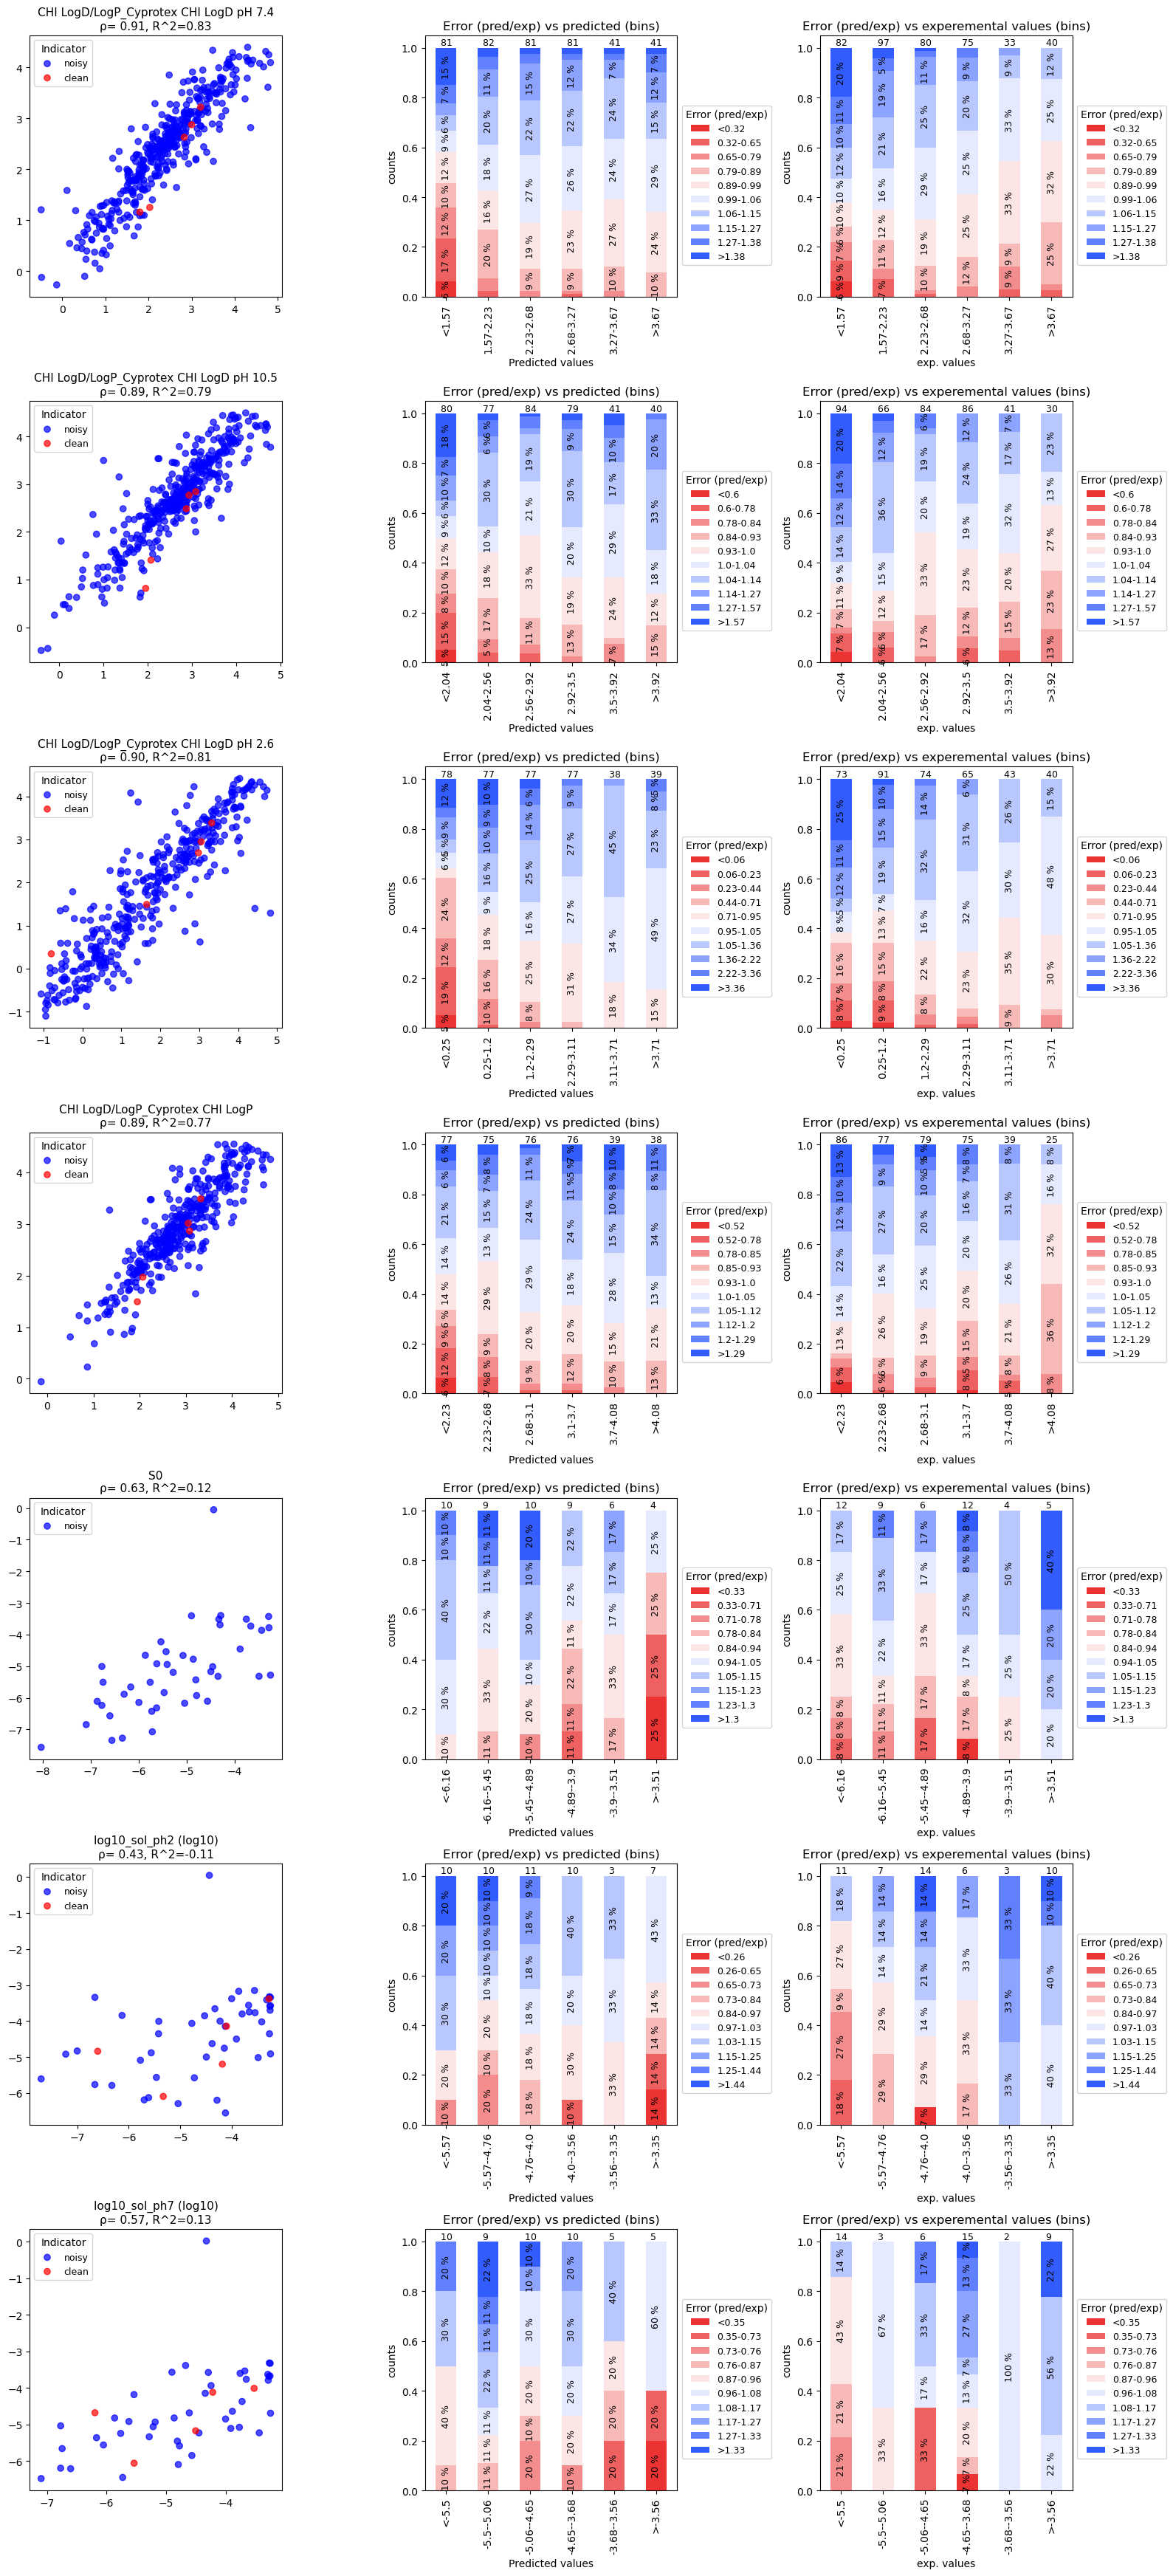

In [28]:
fig, axs = plt.subplots(nrows=len(props), ncols= 3  , figsize=(16,len(props)*5))
i=0
allbins={}


for p in props:
    if 'log10' in p:#not in validation.columns and  f'log10_{p}' in test_df.columns:
        y_true= validation[f'{p}'].values
        #tp='_'.join(p.split('_')[1:])
        y_pred=out[f'predicted_{p}']
    else:
         y_true=validation[f'{p}'].values    
         y_pred=out[f'predicted_{p}']
    mask=np.isnan(y_true)
    y_true=y_true[~mask]
    y_pred=y_pred[~mask]
    if 'log10' in p:    
        #metrics= "ρ= %.2f, R^2=%.2f" % (pearsonr(np.log10(y_true), np.log10(y_pred))[0], r2_score(np.log10(y_true), np.log10(y_pred)))
        metrics= "ρ= %.2f, R^2=%.2f" % (pearsonr((y_true), (y_pred))[0], r2_score((y_true), (y_pred)))
        title= f'{p} (log10)'
    else: 
        metrics= "ρ= %.2f, R^2=%.2f" % (pearsonr((y_true), (y_pred))[0], r2_score((y_true), (y_pred)))
        title=p
    plt.sca(axs.flat[i])
    if len(y_true) < 1000:
        alpha=0.7
    elif len(y_true) < 5000:
        alpha=0.5
    else:
        alpha=0.2
    #l0= round(validation.loc[validation[f'{p}'].notnull(),'acidity'].min(),0)
    #l1= round(validation.loc[validation[f'{p}'].notnull(),'acidity'].max(),0)
    #groups=pd.cut(validation.loc[validation[f'{p}'].notnull(),'Mw'], bins=[ l0,500, 800]).values
    groups=validation.loc[validation[f'{p}'].notnull(),'indicator']
    colors=['blue','red',  'green','gray']
    markers=["s","p","v","^","<"]
    for ind, g in enumerate(groups.unique()):
        #print(g)
        cr =groups== g
        if len(y_true[cr]) <5:
            continue
        plt.scatter(y_true[cr], y_pred[cr],  linestyle='', color=colors[ind], label=g, alpha=alpha )
    plt.title(title+f'\n{metrics}', fontsize=11)
    plt.legend(numpoints=1, loc='upper left', title='Indicator', prop={'size': 9})    
    #plot_reg_model(y_pred,  y_true,alpha=alpha,metrics=metrics, title=title)
    #if 'LogD' not in p and 'Herg' not in p and '30290|EPSA|CMP_DMSO|SFC EPSA' not in p  and 'P450Ccktl' not in p:#and 'Recovery' not in p:
    #if 'log10' in p:
        #axs.flat[i].set_yscale('log')
        #axs.flat[i].set_xscale('log')
    i+=1
    error= abs(y_pred/y_true)
    dftm=pd.DataFrame.from_dict({p:y_true,f'predicted_{p}':y_pred, 'error':error})#, o
    if p in allbins:
        bins=allbins[p]
    else:
        bins=[round(i,2) for i in dftm[f'predicted_{p}'].quantile([0.2,0.4,0.6,0.8,0.9]).values]#[2,3,4,4.5,5,5.5,6,7,9,]# [3,4,5,6,7,9]#range(3,10)
        bins=np.unique(bins)
    bins_err=[round(i,2) for i in dftm['error'].quantile([0.01,0.05,0.1,0.2,0.4,0.6,0.8,0.9,0.95]).values]#[2,3,4,4.5,5,5.5,6,7,9,]# [3,4,5,6,7,9]#range(3,10)
    bins_err=np.unique(bins_err)
    plot_confusion_bars_from_continuos(dftm,pro2='error',pro1=f'predicted_{p}',bins2=bins_err,bins1=bins, 
                  color=['green','yellow','red'], ax=axs.flat[i], 
                  leg_title='Error (pred/exp)',   x_title='Predicted values', title='Error (pred/exp) vs predicted (bins)')
    i+=1
    plot_confusion_bars_from_continuos(dftm,pro2='error',pro1=f'{p}',bins2=bins_err,bins1=bins, 
                  color=['green','yellow','red'], ax=axs.flat[i], 
                  leg_title='Error (pred/exp)',   x_title='exp. values', title='Error (pred/exp) vs experemental values (bins)')

    
    i+=1
  
    
plt.tight_layout()

In [19]:
!conda env export > environment.yml

In [29]:
t = time.localtime()
current_time = time.strftime("%D", t)
print(current_time)

05/11/25


In [30]:
out={}
out['date']= current_time
out['model']= model
out['model_state_dict']= model.state_dict()

torch.save(out, 'clean.pt')